<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/cnn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mohamedeldakrory8/ecg-heart-categorization-dataset-image-version

100% 485M/486M [00:28<00:00, 18.7MB/s]
100% 486M/486M [00:28<00:00, 18.2MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-heart-categorization-dataset-image-version.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!rm /content/ECG-data/train/F/*
!rmdir /content/ECG-data/train/F

In [ ]:
!rm /content/ECG-data/test/F/*
!rmdir /content/ECG-data/test/F

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob

In [ ]:
label = {0: "F", 1: "M",2:"N",3:"Q",4:"S",5:"V"}
print(label)

{0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


In [ ]:
labels=list(label.values())
labels

['F', 'M', 'N', 'Q', 'S', 'V']

In [ ]:
path='/content/ECG-data/train/'
Total_sample=0
for i in labels:
    print(f'Length of :{i}= {len(os.listdir(os.path.join(path,i)))}')
    Total_sample+=len(os.listdir(os.path.join(path,i)))
print(f'Total Samples:{Total_sample}')

Length of :F= 2223
Length of :M= 8000
Length of :N= 72471
Length of :Q= 6431
Length of :S= 2223
Length of :V= 5788
Total Samples:97136


In [ ]:
from tqdm import tqdm
import skimage
import cv2
from skimage.io import imread,imshow
from skimage import transform
img_size=150     # 170x170
X=[] 
Y=[]
i=0
for idx,img in enumerate(labels):
    for img_name in tqdm(os.listdir(path+img)):
        if i<1000:
            img_file=cv2.imread(path+img+'/'+img_name)
            if img_file is not None:
                img_file=transform.resize(img_file,(img_size,img_size,3))
                X.append(img_file)
                Y.append(idx)
        else:
            break
        i=i+1
    i=0
X=np.asarray(X)
Y=np.asarray(Y)

  0%|          | 102/72471 [00:01<19:46, 61.01it/s]

In [ ]:
from random import randint
n = 50  # how many digits we will display
plt.figure(figsize=(90,40))
for i in range(10,20):
    # display original
    rn=randint(0,987)
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X[rn])
    plt.title(labels[Y[rn]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [ ]:
print('Shapes of Data Split into Train & Test Part')
print(f'Training Data->{X_train.shape},{Y_train.shape} Testing Data->{X_test.shape,Y_test.shape}')

Shapes of Data Split into Train & Test Part
Training Data->(4800, 150, 150, 3),(4800,) Testing Data->((1200, 150, 150, 3), (1200,))


In [ ]:
from keras.utils.np_utils import to_categorical
Y_train=to_categorical(Y_train,num_classes=len(labels))
Y_test=to_categorical(Y_test,num_classes=len(labels))

In [ ]:
Y_train.shape,Y_test.shape

((4800, 6), (1200, 6))

In [ ]:
from tensorflow import keras
'''model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])'''
KerasModel = keras.models.Sequential([#bulid nn
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        #1 convolutional layer 200filter each filter 3*3 relu  input 100*100*3 rgb
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
       #2 convolutional layer 150filter each filter 3*3 relu
        keras.layers.MaxPool2D(4,4),
        #3 maxpool layer 4*4
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),
        #4 convolutional layer 120filter each filter 3*3 relu
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'), 
        #5 convolutional layer 80filter each filter 3*3 relu
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        #6 convolutional layer 50filter each filter 3*3 relu
        keras.layers.MaxPool2D(4,4),#7 maxpool layer 4*4
        keras.layers.Flatten(),  #make the matrix flate
        keras.layers.Dense(512,activation='relu') , #hidden layer (120cell)   
        keras.layers.Dense(100,activation='relu') , #hidden layer (100cell)
        keras.layers.Dense(50,activation='relu') ,  #hidden layer (50cell)      
        keras.layers.Dropout(rate=0.5) , 
        #drop some nuron 50% reduces the number of connections to increase speed and reduces the overfit
        keras.layers.Dense(6,activation='softmax') ,  #output layer 6  
    ])
KerasModel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
KerasModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 150)     270150    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 150)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 120)       162120    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 80)        86480     
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 50)        36050     
                                                        

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
history=KerasModel.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=25,batch_size=32,callbacks=checkpoint,verbose=1)

Epoch 1/25
150/150 [==============================] - ETA: 0s - loss: 1.4491 - accuracy: 0.3890
Epoch 1: val_accuracy improved from -inf to 0.71833, saving model to best_model.h5
150/150 [==============================] - 52s 256ms/step - loss: 1.4491 - accuracy: 0.3890 - val_loss: 0.7423 - val_accuracy: 0.7183
Epoch 2/25
150/150 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.7160
Epoch 2: val_accuracy improved from 0.71833 to 0.78833, saving model to best_model.h5
150/150 [==============================] - 37s 249ms/step - loss: 0.7865 - accuracy: 0.7160 - val_loss: 0.5864 - val_accuracy: 0.7883
Epoch 3/25
150/150 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.8010
Epoch 3: val_accuracy improved from 0.78833 to 0.83750, saving model to best_model.h5
150/150 [==============================] - 38s 255ms/step - loss: 0.5575 - accuracy: 0.8010 - val_loss: 0.4712 - val_accuracy: 0.8375
Epoch 4/25
150/150 [==============================] - E

In [ ]:
path2='/content/ECG-data/test/'
img_size=150
x_test=[] 
y_test=[]
i=0
for idx,img in enumerate(labels):
    for img_name in tqdm(os.listdir(path2+img)):
        if i<200:
            img_file=cv2.imread(path2+img+'/'+img_name)
            if img_file is not None:
                img_file=transform.resize(img_file,(img_size,img_size,3))
                x_test.append(img_file)
                y_test.append(idx)
        else:
            break
        i=i+1
    i=0
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

 14%|█▍        | 200/1448 [00:02<00:17, 71.29it/s]


In [ ]:
y_test=to_categorical(y_test,num_classes=len(labels))
print(KerasModel.evaluate(x_test,y_test))

38/38 [==============================] - 3s 82ms/step - loss: 0.7863 - accuracy: 0.8875
[0.7863233685493469, 0.887499988079071]


In [ ]:
results = KerasModel.evaluate(x_test,y_test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

38/38 [==============================] - 3s 82ms/step - loss: 0.7863 - accuracy: 0.8875
Test Loss: 0.78632
Test Accuracy: 88.75%


In [ ]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(x_test,y_test, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.04523
Test Accuracy: 89.83%


Text(0, 0.5, 'loss')

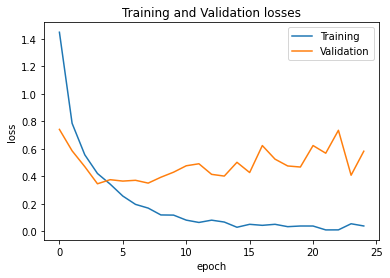

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
     

Text(0, 0.5, 'accuracy')

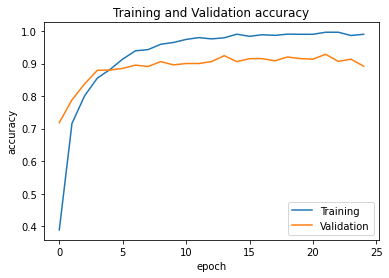

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

38/38 [==============================] - 3s 79ms/step


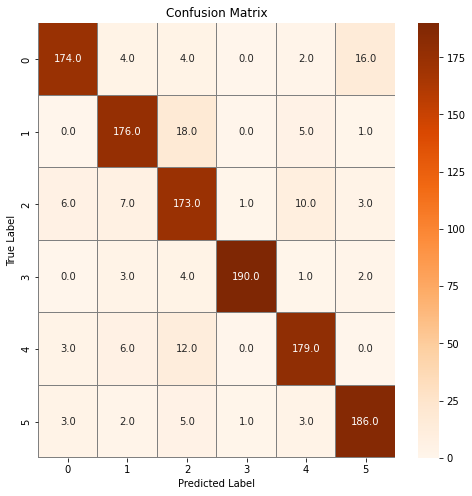

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

Y_pred = best_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes,labels=np.unique(Y_pred_classes)))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       200
           1       0.89      0.88      0.88       200
           2       0.80      0.86      0.83       200
           3       0.99      0.95      0.97       200
           4       0.90      0.90      0.90       200
           5       0.89      0.93      0.91       200

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200



1/1 [==============================] - 0s 20ms/step


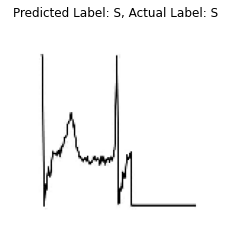

In [ ]:
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG-data/test/S/144.jpg'
test_img = image.load_img(test_image_path, target_size=(150, 150))
test_img_arr = image.img_to_array(test_img)/255
test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

# 2. Make Predictions
predicted_label = np.argmax(KerasModel.predict(test_img_input))
predicted_beat = labels[predicted_label]
plt.figure(figsize=(4, 4))
plt.imshow(test_img_arr)
plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, 'S'))
plt.grid()
plt.axis('off')
plt.show()